# How big is French Industry? [Data Visualization]
***

<img src='https://upload.wikimedia.org/wikipedia/commons/e/e6/Paris_Night.jpg'>

# Table of Contents

* [1. Importing dataset and data preprocessing](#importing_dataset_and_data_preprocessing) <br>
   * [1.1. Dataset import](#dataset_import) <br>
   * [1.2. Let's summarize the Dataset](#lets_summarize_the_dataset) <br>
   * [1.3. Data preprocessing & feature engineering](#data_preprocessing) <br>
      * [1.3.1. Geography dataset preprocessing](#geography_dataset_preprocessing) <br>
      * [1.3.2. Industry dataset preprocessing](#industry_dataset_preprocessing) <br>
      * [1.3.3. Merging datasets](#lets_look_at_it_from_a_birds_eye_view) <br>
<br>
* [2. Data visualization](#data_visualization) <br>
   * [2.1. Let's look at it from a bird's eye view](#lets_look_at_it_from_a_birds_eye_view) <br>

## 1. Importing dataset and data preprocessing
<a id="importing_dataset_and_data_preprocessing"></a>

In [104]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [27]:
geography = pd.read_csv("../00_Datasets/French_firms/name_geographic_information.csv")
industry = pd.read_csv("../00_Datasets/French_firms/base_etablissement_par_tranche_effectif.csv")

### 1.2. Let's try to summarize the Dataset
<a id="lets_summarize_the_dataset"></a>

In [28]:
geography.head(3)

,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
0,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Attignat,01340,1024,46.283333,5.166667,1.21
1,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Beaupont,01270,1029,46.400000,5.266667,1.91
2,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bény,01370,1038,46.333333,5.283333,1.51


In [29]:
geography.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36840 entries, 0 to 36839
Data columns (total 14 columns):
EU_circo                  36840 non-null object
code_région               36840 non-null int64
nom_région                36840 non-null object
chef.lieu_région          36840 non-null object
numéro_département        36840 non-null object
nom_département           36840 non-null object
préfecture                36840 non-null object
numéro_circonscription    36840 non-null int64
nom_commune               36840 non-null object
codes_postaux             36840 non-null object
code_insee                36840 non-null int64
latitude                  33911 non-null float64
longitude                 33999 non-null object
éloignement               33878 non-null float64
dtypes: float64(2), int64(3), object(9)
memory usage: 3.9+ MB


In [30]:
industry.head(3)

,CODGEO,LIBGEO,REG,DEP,E14TST,E14TS0ND,E14TS1,E14TS6,E14TS10,E14TS20,E14TS50,E14TS100,E14TS200,E14TS500
0,01001,L'Abergement-Clémenciat,82,01,25,22,1,2,0,0,0,0,0,0
1,01002,L'Abergement-de-Varey,82,01,10,9,1,0,0,0,0,0,0,0
2,01004,Ambérieu-en-Bugey,82,01,996,577,272,63,46,24,9,3,2,0


In [31]:
industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36681 entries, 0 to 36680
Data columns (total 14 columns):
CODGEO      36681 non-null object
LIBGEO      36681 non-null object
REG         36681 non-null int64
DEP         36681 non-null object
E14TST      36681 non-null int64
E14TS0ND    36681 non-null int64
E14TS1      36681 non-null int64
E14TS6      36681 non-null int64
E14TS10     36681 non-null int64
E14TS20     36681 non-null int64
E14TS50     36681 non-null int64
E14TS100    36681 non-null int64
E14TS200    36681 non-null int64
E14TS500    36681 non-null int64
dtypes: int64(11), object(3)
memory usage: 3.9+ MB


### 1.3. Data preprocessing & feature engineering|
<a id="data_preprocessing"></a>

### 1.3.1. Geography dataset preprocessing
<a id="geography_dataset_preprocessing"></a>

<b>NOTE:</b> Before we start any operations on Data Frames let's translate columns names to english.

In [32]:
geography.rename(columns={'code_région': 'region_code', 
                          'nom_région': 'region_name',
                          'chef.lieu_région': 'region_capital',
                          'numéro_département': 'department_number',
                          'nom_département': 'department_name',
                          'préfecture': 'prefecture',
                          'numéro_circonscription': 'constituency_number',
                          'nom_commune': 'common_name',
                          'codes_postaux': 'postcodes'}, inplace=True)

<b>NOTE:</b> Unfortunately, some of the data in geography DataFrame is incorrect or incomplete. First we will focus on longitude column. We will convert commas to dots to create a correct number [1]. Then we will delete the incorrect entries [2] and empty fields [3]. Finally, we will switch the column type to float [4].

In [33]:
# 1
geography["longitude"] = geography["longitude"].apply(lambda x: str(x).replace(',','.'))
# 2
mask = geography["longitude"] == '-'
geography.drop(geography[mask].index, inplace=True)
# 3
geography.dropna(subset = ["longitude", "latitude"], inplace=True)
# 4
geography["longitude"] = geography["longitude"].astype(float)

In [53]:
geography.drop_duplicates(subset=["code_insee"], keep="first", inplace=True)

### 1.3.2. Industry dataset preprocessing
<a id="industry_dataset_preprocessing"></a>

<b>NOTE:</b> We are going to switch "CODGEO" column type from object (string) to int, but first we need to get rid of incorrect rows. Some of rows contain non numeric characters. We will select only those values that can be transformed into numbers.

In [54]:
industry = industry[industry["CODGEO"].apply(lambda x: str(x).isdigit())]

In [55]:
industry["CODGEO"] = industry["CODGEO"].astype(int)

### 1.3.3. Merging datasets
<a id="merging_datasets"></a>

In [56]:
full_data = industry.merge(geography, how="left", left_on = "CODGEO", right_on="code_insee")

In [57]:
full_data.head(3)

,CODGEO,LIBGEO,REG,DEP,E14TST,E14TS0ND,E14TS1,E14TS6,E14TS10,E14TS20,...,department_number,department_name,prefecture,constituency_number,common_name,postcodes,code_insee,latitude,longitude,éloignement
0,1001,L'Abergement-Clémenciat,82,01,25,22,1,2,0,0,...,01,Ain,Bourg-en-Bresse,4.0,L'Abergement-Clémenciat,01400,1001.0,46.15,4.916667,1.46
1,1002,L'Abergement-de-Varey,82,01,10,9,1,0,0,0,...,01,Ain,Bourg-en-Bresse,2.0,L'Abergement-de-Varey,01640,1002.0,46.00,5.416667,1.00
2,1004,Ambérieu-en-Bugey,82,01,996,577,272,63,46,24,...,01,Ain,Bourg-en-Bresse,2.0,Ambérieu-en-Bugey,01500,1004.0,45.95,5.350000,0.80


## 2. Data visualization
<a id="data_visualization"></a>

### 2.1. Let's look at it from a bird's eye view
<a id="lets_look_at_it_from_a_birds_eye_view"></a>

In [119]:
# Creating DataFrame containing cities with the highiest number of workplaces
top_industry = full_data.sort_values(by=["E14TST"], ascending=False).head(10)

In [120]:
# Preparing information to mark cities with highiest number of workplaces
top_industry_names = top_industry["LIBGEO"].values.tolist()
top_industry_lons = top_industry["longitude"].values.tolist()
top_industry_lats = top_industry["latitude"].values.tolist()

In [121]:
lons = full_data["longitude"].values.tolist()
lats = full_data["latitude"].values.tolist()
size = (full_data["E14TST"]/10).values.tolist()

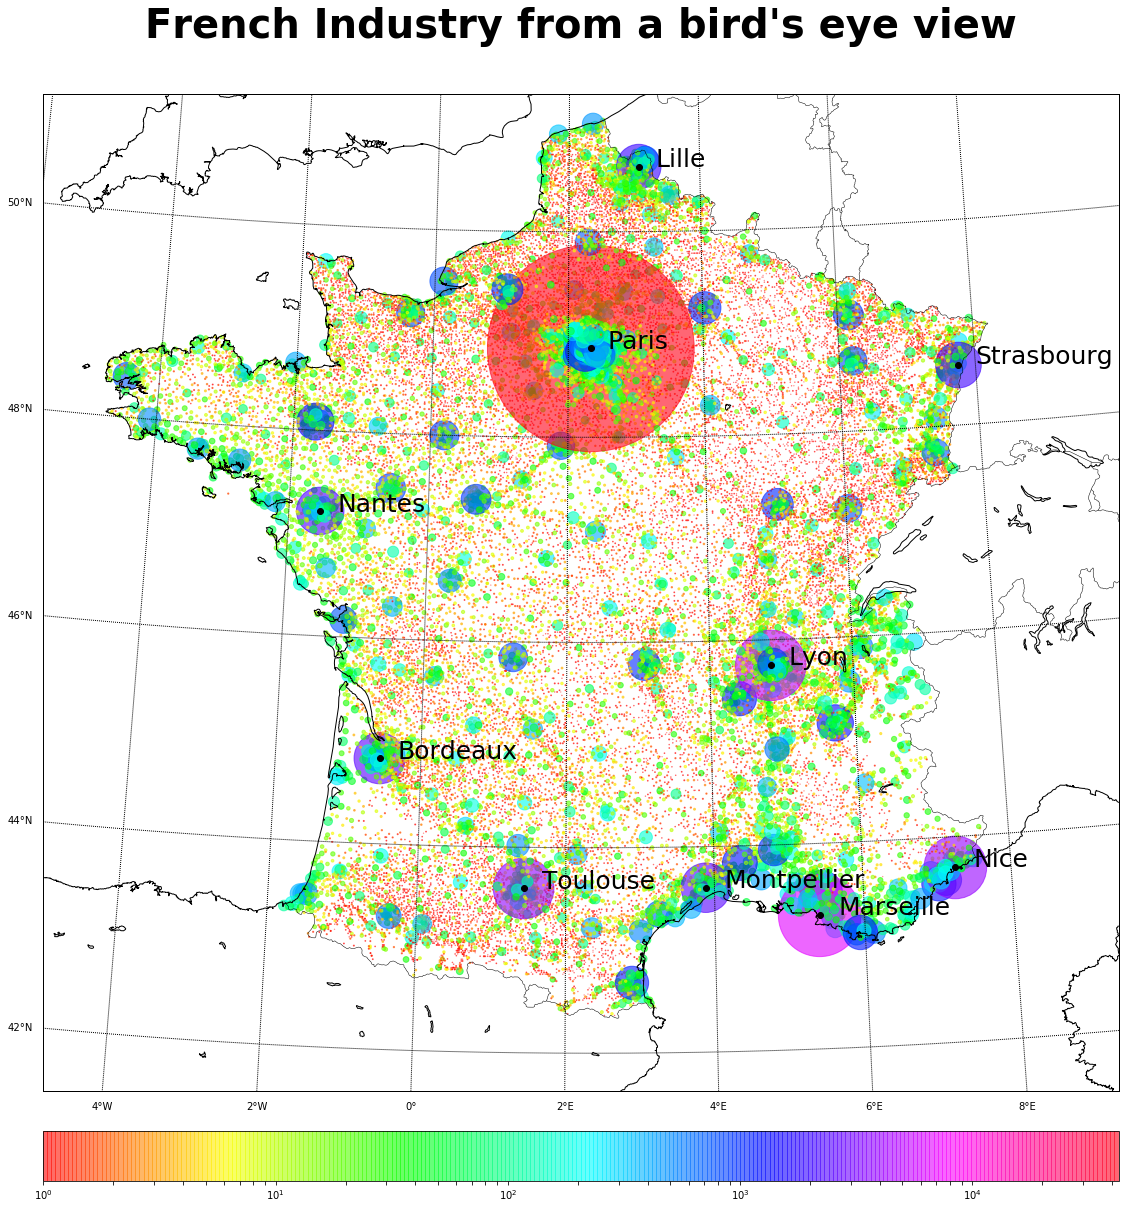

In [128]:
# Creating new plot
plt.figure(figsize=(20,20))
# Load map of France
map = Basemap(projection='lcc', 
            lat_0=46.2374,
            lon_0=2.375,
            resolution='h',
            llcrnrlon=-4.76, llcrnrlat=41.39,
            urcrnrlon=10.51, urcrnrlat=51.08)

# Draw parallels.
parallels = np.arange(40.,52,2.)
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# Draw meridians
meridians = np.arange(-6.,10.,2.)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()

# Draw scatter plot with all cities
x,y = map(lons, lats)
map.scatter(x, y, s=size, alpha=0.6, c=size, norm=colors.LogNorm(vmin=1, vmax=max(size)), cmap='hsv')
map.colorbar(location="bottom", pad="4%")

# Draw scatter plot of cities with highiest number of workplaces
x1, y1 = map(top_industry_lons, top_industry_lats)
map.scatter(x1, y1, c="black")

for i in range(len(top_industry_names)):
    plt.annotate(top_industry_names[i], xy=(map(top_industry_lons[i] + 0.25,  top_industry_lats[i])), fontsize=25)

plt.title("French Industry from a bird's eye view", fontsize=40, fontweight='bold', y=1.05)   

plt.show()

<b>NOTE:</b> Right awey we see that Paris is city with the highiest number of workplaces in France. I also marked nine other cities that are top job providers. Three of those cities [Mintpellier, Marseille and Nice] are located on French Riviera. Let's take a closer look at this part of France.

### 2.2. French Riviera
<a id="french_riviera"></a>

In [148]:
# Lets cut smaller cut of the map and focus on  French Riviera
lons_min = 3
lons_max = 8
lats_min = 42.5
lats_max = 45

mask_lons = (full_data["longitude"] > lons_min) & (full_data["longitude"] < lons_max)
mask_lats = (full_data["latitude"] > lats_min) & (full_data["latitude"] < lats_max)
franch_riviera = full_data[mask_lons & mask_lats]

lons = franch_riviera["longitude"].values.tolist()
lats = franch_riviera["latitude"].values.tolist()
size = (franch_riviera["E14TST"]/5).values.tolist()

# Creating DataFrame containing cities with the highiest number of workplaces
top_industry = franch_riviera.sort_values(by=["E14TST"], ascending=False).head(5)

# Preparing information to mark cities with highiest number of workplaces
top_industry_names = top_industry["LIBGEO"].values.tolist()
top_industry_lons = top_industry["longitude"].values.tolist()
top_industry_lats = top_industry["latitude"].values.tolist()

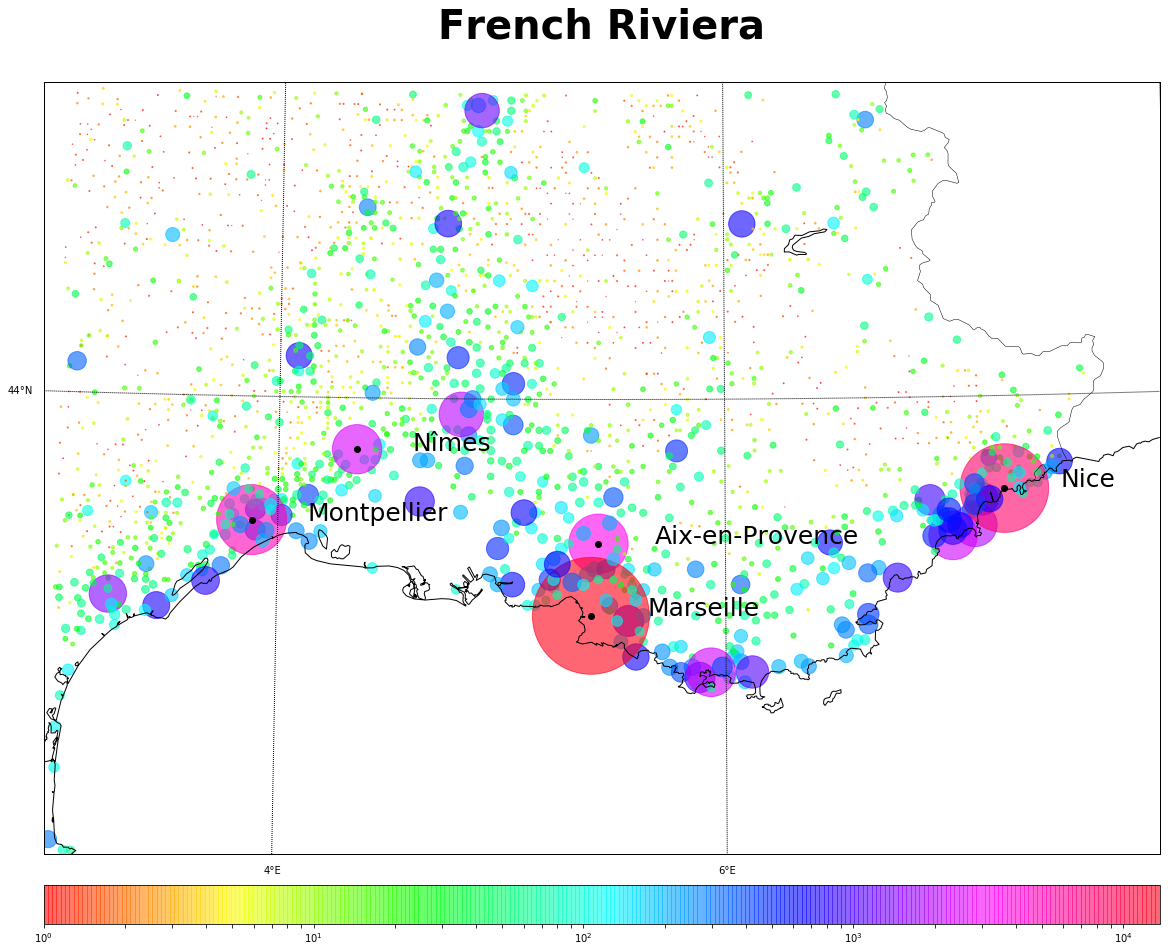

In [147]:
# Creating new plot
plt.figure(figsize=(20,20))
# Load map of France
map = Basemap(projection='lcc', 
            lat_0=(lats_min + lats_max)/2,
            lon_0=(lons_min + lons_max)/2,
            resolution='h',
            llcrnrlon=lons_min, llcrnrlat=lats_min,
            urcrnrlon=lons_max, urcrnrlat=lats_max)

# Draw parallels.
parallels = np.arange(40.,52,2.)
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# Draw meridians
meridians = np.arange(-6.,10.,2.)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()

# Draw scatter plot with all cities
x,y = map(lons, lats)
map.scatter(x, y, s=size, alpha=0.6, c=size, norm=colors.LogNorm(vmin=1, vmax=max(size)), cmap='hsv')
map.colorbar(location="bottom", pad="4%")

# Draw scatter plot of cities with highiest number of workplaces
x1, y1 = map(top_industry_lons, top_industry_lats)
map.scatter(x1, y1, c="black")

for i in range(len(top_industry_names)):
    plt.annotate(top_industry_names[i], xy=(map(top_industry_lons[i] + 0.25,  top_industry_lats[i])), fontsize=25)

plt.title("French Riviera", fontsize=40, fontweight='bold', y=1.05)  

plt.show()

# To be continued...

Next, we will take a look into job distribution in top cities.